# HW 4:  Portfolio Returns & Risk + MVO

In this assignment,
we will explore portfolio returns and risk using historical price data for AMZN, IGLB, and SPY from 2014 to 2019.

Our tasks include:
*   We'll normalize IGLB's 'Close' and 'Adj Close' prices to compare their performance.
*   We'll filter and merge the adjusted closing prices for all three securities.
*   We'll calculate log returns, plot cumulative NAV lines, and analyze summary statistics.
*   We'll examine correlations, calculate Sharpe ratios, and speculate on optimal portfolios.
*   Using Monte Carlo simulations, we'll generate an efficient frontier to identify optimal portfolios based on risk and return.





In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker

In [112]:
# Define the aspect ratio for plots
aspect_ratio=(12,8) # for inline
# aspect_ratio=(8,5) for qt

# Helper Functions from previous assignments:

*   read_price_data
*   plot_and_format_y_axis
*   print_pct_data
*   calcPerformanceStatistics



In [113]:
# Creating a function to read price data from csv files
def read_price_data(filename, index_col=0, parse_dates=True):
    # Load the data
    data = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)

    # Print DataFrame info
    print("DataFrame Info:")
    data.info()

    # Check for any null values
    print("\nChecking for null values:")
    print(data.isnull().sum())

    # Print summary statistics
    print("\nSummary Statistics:")
    print(data.describe())

    # Display the DataFrame
    print("\nDataFrame Preview:")
    print(data.head())

    return data

In [114]:
# Create the function for plotting and formatting Y-axis
def plot_and_format_y_axis(data_frame, formatter=ticker.ScalarFormatter(), aspect_ratio=(12, 8), title='', ylabel='', grid=True, label=None):
    # Set the axis based on optional parameters
    ax = data_frame.plot(figsize=aspect_ratio, title=title, grid=grid, label=label)
    ax.set_ylabel(ylabel)

    # Apply the custom formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)

    # Print legend if label is provided
    if label is not None:
        plt.legend()

    plt.show()

In [115]:
def print_pct_data(df_input, fmt_spec=".4f", nan_placeholder='NaN', index_slice=None):
    # Create a lambda function for custom formatting and NaN handling
    formatter_lambda = lambda x: nan_placeholder if pd.isna(x) else f"{x * 100:{fmt_spec}}%"

    # Make a copy of the input DataFrame
    formatted_df = df_input.copy()

    # If index_slice is provided, apply formatting only to the specified rows/columns
    if index_slice is not None:
        formatted_df.loc[index_slice] = formatted_df.loc[index_slice].apply(lambda col: col.map(formatter_lambda))
    else:
        # Apply the lambda function to the entire DataFrame
        formatted_df = formatted_df.apply(lambda col: col.map(formatter_lambda))

    return formatted_df

def calcPerformanceStatistics(dataFrame, annualization_factor=260, print_Screen=True, percent_format_string=".2f"):
    #---------------------------------------------------------------------------
    # Challenge: Perform error-checking on the input dataFrame
    #---------------------------------------------------------------------------

    # Check if the first row has NaN values in all columns
    if dataFrame.iloc[0].notna().any():
        # If not, insert a new NaN row at the top (simulating t-1 business day)
        # Create a NaN row with the same columns as the input DataFrame
        nan_row = pd.Series([pd.NA] * len(dataFrame.columns), index=dataFrame.columns)
        # Insert the NaN row at the top (index 0)
        dataFrame = pd.concat([pd.DataFrame([nan_row]), dataFrame], ignore_index=True)

    # Check if any row other than the first contains NaN values
    if dataFrame.iloc[1:].isna().any().any():
        raise ValueError("NaN values are not allowed outside the first row")

    # Drop the first NaN row and fill the remaining NaNs (if any) using forward fill
    dataFrame = dataFrame.dropna().ffill()

    #---------------------------------------------------------------------------
    # Actual implementation
    #---------------------------------------------------------------------------

    # Cumulate the dataframe (log returns) to get cumulative returns
    cum_returns = dataFrame.cumsum().fillna(0)

    # Create underwater curve
    underwater_curve = cum_returns.fillna(0) - np.maximum.accumulate(cum_returns.fillna(0))

    # Calculate summary statistics
    avg_annual_return = annualization_factor * dataFrame.mean()
    annual_risk = np.sqrt(annualization_factor) * dataFrame.std()
    sharpe_ratio = (dataFrame.mean() / dataFrame.std()) * np.sqrt(annualization_factor)
    max_drawdown = underwater_curve.min()
    success_ratio = (dataFrame > 0).mean()

    # Create a DataFrame to summarize the statistics
    summary_stats = pd.DataFrame({
        'Annual Return': avg_annual_return,
        'Annualized Risk': annual_risk,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Success Ratio': success_ratio
    })

    # Print the generated summary statistics if print_Screen is True
    if print_Screen:
        # Display the performance statistics
        return print_pct_data(summary_stats,
                             fmt_spec=percent_format_string,
                             index_slice=pd.IndexSlice[:, ['Annual Return', 'Annualized Risk', 'Max Drawdown', 'Success Ratio']])

    # Return the summary statistics if not print_Screen
    return summary_stats

#Q1: Data Preparation for AMZN, IGLB, and SPY

We use the provided price data for AMZN, IGLB, and SPY, covering the period from December 31, 2014, to December 31, 2019. This ensures a consistent timeframe for analysis.

In [116]:
# Read AMZN CSV files into dataframes
amzn_data = read_price_data("AMZN.csv", index_col=0, parse_dates=True)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2014-12-31 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB

Checking for null values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Summary Statistics:
              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean     55.742699    56.241898    55.145867    55.720409    55.720409   
std      26.638782    26.865552    26.335057    26.610040    26.610040   
min      14.314000    14.539500    14.2625

In [117]:
# Read IGLB CSV files into dataframes
iglb_data = read_price_data("IGLB.csv", index_col=0, parse_dates=True)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2014-12-31 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB

Checking for null values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Summary Statistics:
              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean     60.247323    60.404964    60.060762    60.239825    47.644273   
std       2.939939     2.948854     2.930663     2.947619     4.193776   
min      55.090000    55.189999    55.0000

In [118]:
# Read SPY CSV files into dataframes
spy_data = read_price_data("SPY.csv", index_col=0, parse_dates=True)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2014-12-31 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB

Checking for null values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Summary Statistics:
              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    245.057316   246.109682   243.860929   245.077720   218.417080   
std      35.635148    35.682415    35.537681    35.608086    37.666626   
min     182.339996   184.100006   181.0200

In [119]:
# Verify the start and end dates
print("Start Date for AMZN:", amzn_data.index.min())
print("Start Date for IGLB:",iglb_data.index.min())
print("Start Date for SPY :",spy_data.index.min())
print("\nEnd Date for AMZN:", amzn_data.index.max())
print("End Date for IGLB:",iglb_data.index.max())
print("End Date for SPY :",spy_data.index.max())

Start Date for AMZN: 2014-12-31 00:00:00
Start Date for IGLB: 2014-12-31 00:00:00
Start Date for SPY : 2014-12-31 00:00:00

End Date for AMZN: 2019-12-31 00:00:00
End Date for IGLB: 2019-12-31 00:00:00
End Date for SPY : 2019-12-31 00:00:00


# Q2: Normalized Portfolio of IGLB

For IGLB, we calculate a normalized portfolio with a starting value of $1 for both 'Close' and 'Adj Close' prices. The plot shows how each price evolves over time, highlighting that the 'Adj Close' price outperforms due to adjustments for dividends and other corporate actions.

In [120]:
initial_investment = 1

# Normalize the 'Close' and 'Adj Close' prices to a $1 initial value
normalized_portfolio = pd.DataFrame({
    'Close': (iglb_data['Close'] / iglb_data['Close'].iloc[0]) * initial_investment,
    'Adj Close': (iglb_data['Adj Close'] / iglb_data['Adj Close'].iloc[0]) * initial_investment
})


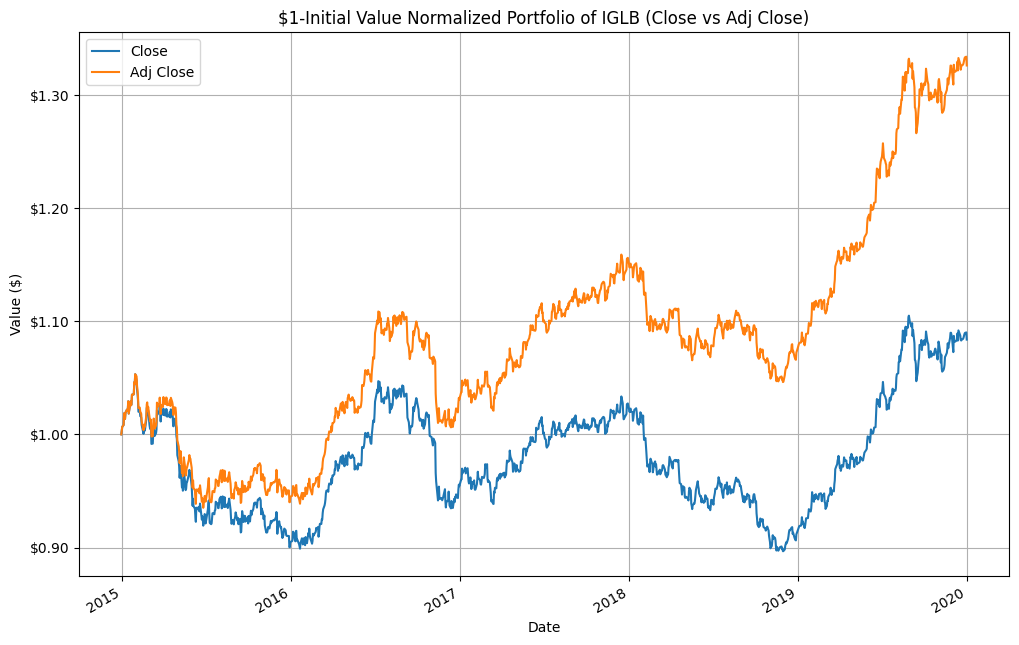

In [121]:
# Plot the normalized portfolio
plot_and_format_y_axis(normalized_portfolio,
                       title="$1-Initial Value Normalized Portfolio of IGLB (Close vs Adj Close)",
                       formatter=ticker.StrMethodFormatter('${x:,.2f}'),
                       ylabel="Value ($)")

In [122]:
# Calculate the performance difference
performance_diff = (normalized_portfolio['Adj Close'].iloc[-1] - normalized_portfolio['Close'].iloc[-1]) / normalized_portfolio['Close'].iloc[-1] * 100

print(f"The 'Adj Close' price outperforms the 'Close' price by {performance_diff:.2f}%")

The 'Adj Close' price outperforms the 'Close' price by 22.34%


The Adjusted Close price often outperforms the Close price due to its inclusion of dividends and other corporate actions, such as stock splits. Here's why this is significant for IGLB:

Dividends:
IGLB, being a bond ETF, likely pays regular dividends. The Adjusted Close price accounts for these dividends, reflecting their reinvestment, which can significantly enhance returns over time.

Corporate Actions: Adjusted Close prices also account for stock splits and other corporate actions that affect a stock's value. This provides a more accurate picture of an asset's performance by adjusting historical prices to reflect these events.

Long-term Performance: For long-term investors, the Adjusted Close price offers a clearer view of total returns, including income from dividends, making it a more comprehensive measure than the raw Close price.

In summary, the Adjusted Close price gives a more complete picture of an investment's value by incorporating dividends and other factors that the Close price does not consider. This results in the Adjusted Close price often outperforming the Close price, as seen with IGLB.

#Q3: Filtering and Merging Adjusted Close Prices

We filter out all columns except the 'Adj Close' prices for AMZN, IGLB, and SPY. These are then joined into a single DataFrame with appropriately named columns, facilitating comparative analysis across these securities.


In [123]:
# Filter out all columns except the 'Adj Close' price, then rename them
amzn_adj_close = amzn_data[['Adj Close']].rename(columns={'Adj Close': 'AMZN'})
iglb_adj_close = iglb_data[['Adj Close']].rename(columns={'Adj Close': 'IGLB'})
spy_adj_close = spy_data[['Adj Close']].rename(columns={'Adj Close': 'SPY'})

# Join the dataframes
merged_data = amzn_adj_close.join([iglb_adj_close, spy_adj_close], how='inner')

# Display the merged DataFrame
print(merged_data.head())

               AMZN       IGLB         SPY
Date                                      
2014-12-31  15.5175  43.992218  173.797897
2015-01-02  15.4260  44.285408  173.704941
2015-01-05  15.1095  44.356926  170.567886
2015-01-06  14.7645  44.764515  168.961319
2015-01-07  14.9210  44.828884  171.066818


# Q4: Log Returns, NAVs and Summary Statistics
We shall now calculate and pretty-print the log returns of the three securities, then calculate and "pretty-plot" the Cumulative Log Returns (NAVs) and finally show off the the Summary Statistics for each of the three securities.

In [124]:
# Calculate log returns using shift method
log_returns = np.log(merged_data / merged_data.shift(1))

# Pretty print the log returns
print_pct_data(log_returns)

,AMZN,IGLB,SPY
Date,,,
2014-12-31,NaN,NaN,NaN
2015-01-02,-0.5914%,0.6642%,-0.0535%
2015-01-05,-2.0731%,0.1614%,-1.8225%
2015-01-06,-2.3098%,0.9147%,-0.9464%
2015-01-07,1.0544%,0.1437%,1.2384%
...,...,...,...
2019-12-24,-0.2116%,0.0899%,0.0031%
2019-12-26,4.3506%,0.2991%,0.5309%
2019-12-27,0.0551%,0.0895%,-0.0248%


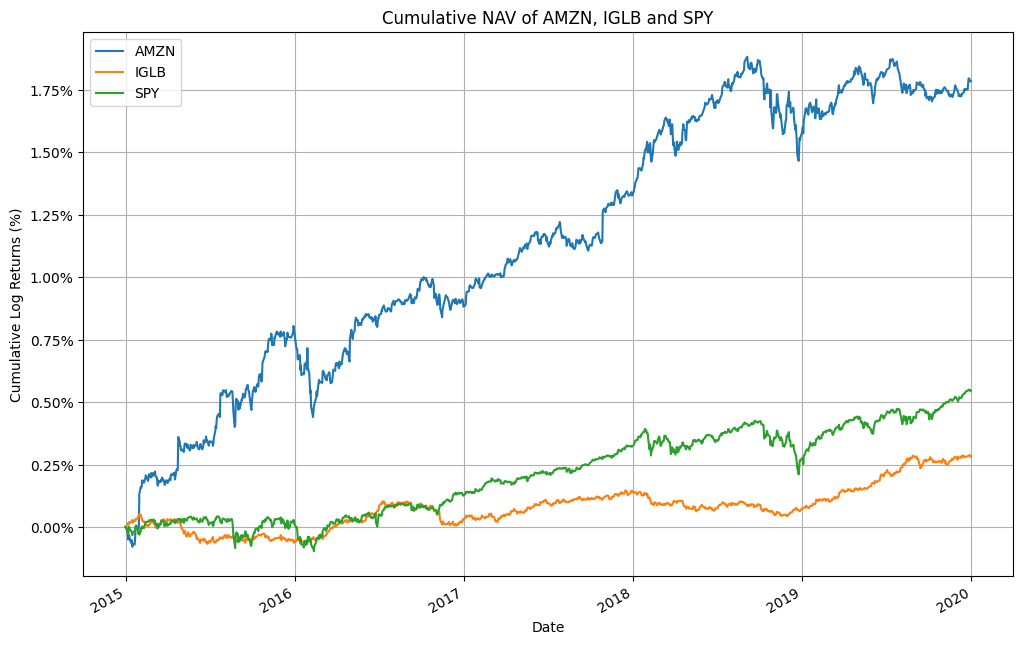

In [125]:
# Cumulate the log returns into a NAV dataframe, without forgetting to fillna() afterwards
cum_returns = log_returns.cumsum().fillna(0)

# "Pretty-plot" the cumulative returns
plot_and_format_y_axis(cum_returns,
                       title="Cumulative NAV of AMZN, IGLB and SPY",
                       formatter=ticker.StrMethodFormatter('{x:,.2f}%'),
                       ylabel="Cumulative Log Returns (%)")

In [126]:
# Calculative and display summary statistics
calcPerformanceStatistics(log_returns)

,Annual Return,Annualized Risk,Sharpe Ratio,Max Drawdown,Success Ratio
AMZN,36.87%,29.43%,1.253010,-41.71%,54.85%
IGLB,5.83%,7.71%,0.755891,-11.88%,53.18%
SPY,11.30%,13.66%,0.827757,-21.50%,54.37%


# Q5: Correlation table of log returns
We shall now create a correlation table of the logarithmic returns. Then, we shall intrepret the correlation table, before speculating on which security would dominate for min-vol portfolio as well as for max Sharpe Ratio portfolio.

In [127]:
log_returns.corr()

,AMZN,IGLB,SPY
AMZN,1.000000,0.021806,0.612251
IGLB,0.021806,1.000000,-0.062105
SPY,0.612251,-0.062105,1.000000


#### Inferences from the correlation table:
- **AMZN and SPY** have a moderately positive correlation (0.612), meaning they tend to move in the same direction.
- **IGLB** is weakly correlated with both AMZN (0.021) and SPY (-0.062), offering good diversification potential.

#### Speculation on Dominating Securities:
- **Min-Vol Portfolio**: **IGLB** will likely dominate due to its low volatility and weak correlations with the other assets, making it the best candidate for reducing portfolio risk.
- **Max-Sharpe Portfolio**: **AMZN** will likely dominate because it has the highest Sharpe ratio (1.253), offering the best risk-adjusted return.

# Q6: Efficient Frontier Generation
We shall now run a Monte Carlo simulation based on the specified factors to generate an efficient frontier for further analysis.

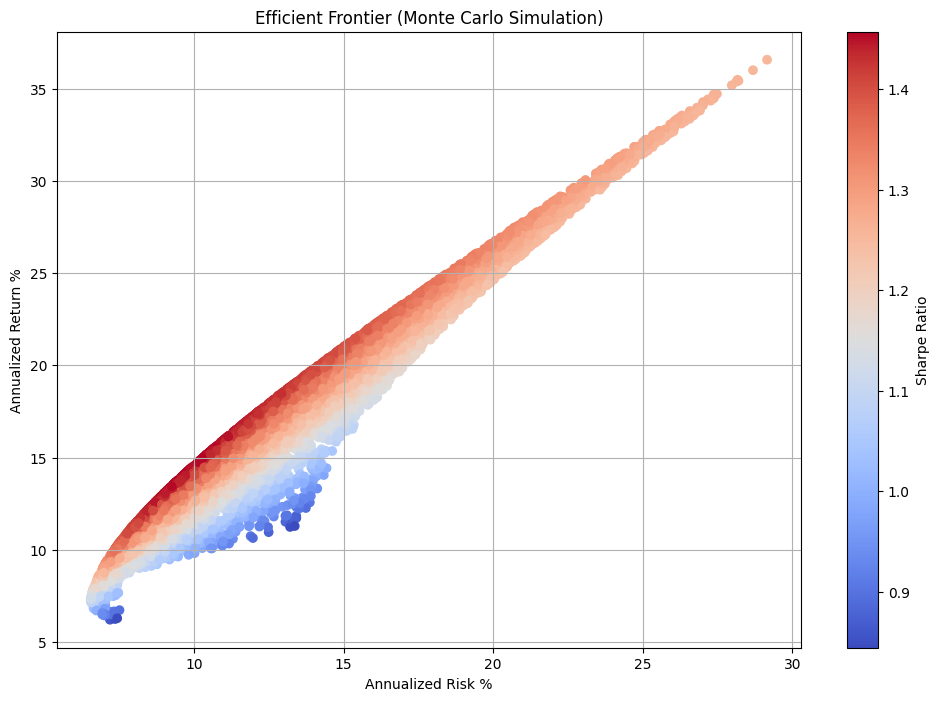

In [128]:
# Set Seed for reproducibility
rng = np.random.default_rng(seed=64)
# Set the number of assets (three)
num_assets = log_returns.shape[1]
# Set the number of simulations
num_simulations = 10000
# Set the annualization factor
annualization_factor = 260

# Initialize lists to store weights, returns, risks, Sharpe ratio
all_weights = np.zeros((num_simulations, num_assets))
ret_arr = np.zeros(num_simulations)
risk_arr = np.zeros(num_simulations)
sharpe_arr = np.zeros(num_simulations)

# Run the Monte Carlo simulation
for i in range(num_simulations):
    # Generate random weights and normalize them
    wts = rng.random(num_assets)
    wts /= np.sum(wts)

    # Save the weights
    all_weights[i, :] = wts

    # Calculate the annualized portfolio return and risk
    ret_arr[i] = np.sum(wts * log_returns.mean()) * annualization_factor
    risk_arr[i] = np.sqrt(np.dot(wts.T, np.dot(log_returns.cov() * annualization_factor, wts)))

    # Calculate the Sharpe ratio
    sharpe_arr[i] = ret_arr[i] / risk_arr[i]

# Plot the efficient frontier
plt.figure(figsize=aspect_ratio)
plt.scatter(risk_arr * 100, ret_arr * 100, c=sharpe_arr, cmap='coolwarm', marker='o')
plt.title('Efficient Frontier (Monte Carlo Simulation)')
plt.xlabel('Annualized Risk %')
plt.ylabel('Annualized Return %')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

# Q7: Plot, as we did in class, the risk/return scatter plot of all the 10,000 portfolios, ensuring that axes are formatted correctly in percentages.

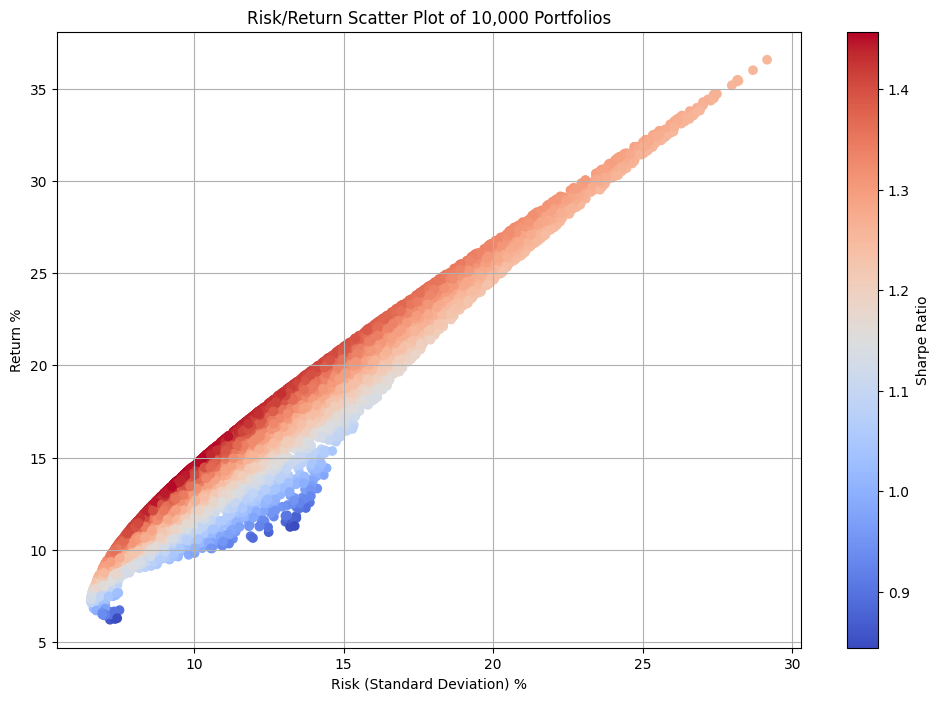

In [129]:
plt.figure(figsize=(12, 8))

# Scatter plot for risk (X) vs return (Y)
plt.scatter(risk_arr * 100, ret_arr * 100, c=sharpe_arr, cmap='coolwarm', marker='o')

# Formatting the axes
plt.title('Risk/Return Scatter Plot of 10,000 Portfolios')
plt.xlabel('Risk (Standard Deviation) %')
plt.ylabel('Return %')
plt.grid(True)

# Display color bar for Sharpe ratio
plt.colorbar(label='Sharpe Ratio')
plt.show()


# Q8: Include, in the above plot, a colorbar based on the Sharpe ratio, and use the reverse colormap as we did in class.

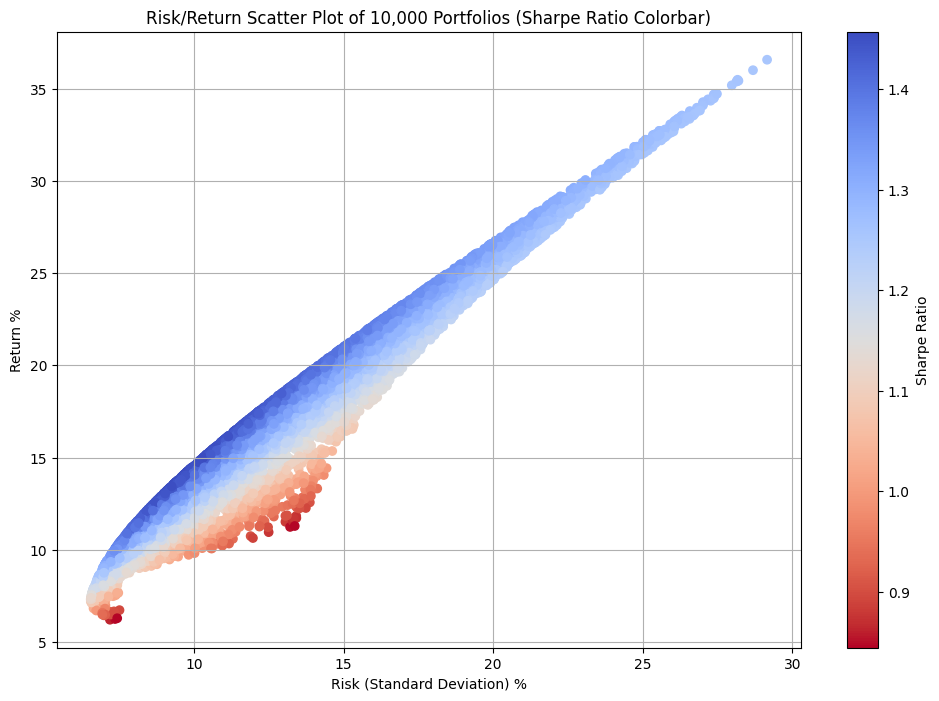

In [130]:
plt.figure(figsize=(12, 8))

# Scatter plot with reversed colormap coolwarm_r (blue for high Sharpe, red for low Sharpe)
plt.scatter(risk_arr * 100, ret_arr * 100, c=sharpe_arr, cmap='coolwarm_r', marker='o')

# Formatting the axes
plt.title('Risk/Return Scatter Plot of 10,000 Portfolios (Sharpe Ratio Colorbar)')
plt.xlabel('Risk (Standard Deviation) %')
plt.ylabel('Return %')
plt.grid(True)

# Display color bar with reversed colormap
plt.colorbar(label='Sharpe Ratio')
plt.show()


# Q9: Mark the minimum vol portfolio with a markersize=10 blue star

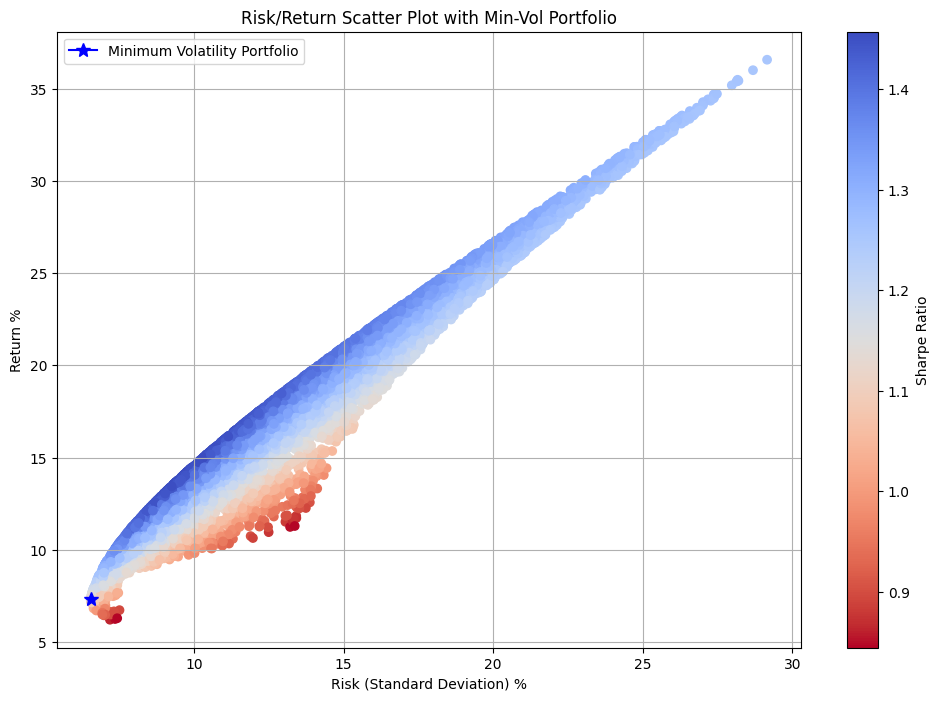

In [131]:
# Find index of the minimum volatility (risk) portfolio
min_vol_index = np.argmin(risk_arr)
max_sharpe_index = np.argmax(sharpe_arr)

plt.figure(figsize=(12, 8))

# Plot all portfolios using scatter
plt.scatter(risk_arr * 100, ret_arr * 100, c=sharpe_arr, cmap='coolwarm_r', marker='o')

# Highlight the minimum volatility portfolio with a blue star and markersize=10
plt.plot(risk_arr[min_vol_index] * 100, ret_arr[min_vol_index] * 100, color='blue', marker='*', markersize=10, label='Minimum Volatility Portfolio')

# Formatting the axes
plt.title('Risk/Return Scatter Plot with Min-Vol Portfolio')
plt.xlabel('Risk (Standard Deviation) %')
plt.ylabel('Return %')
plt.grid(True)

# Add a color bar for Sharpe ratio
plt.colorbar(label='Sharpe Ratio')

# Add the legend
plt.legend()
plt.show()


# Q10: Mark the maximum Sharpe portfolio with a markersize=10 red star

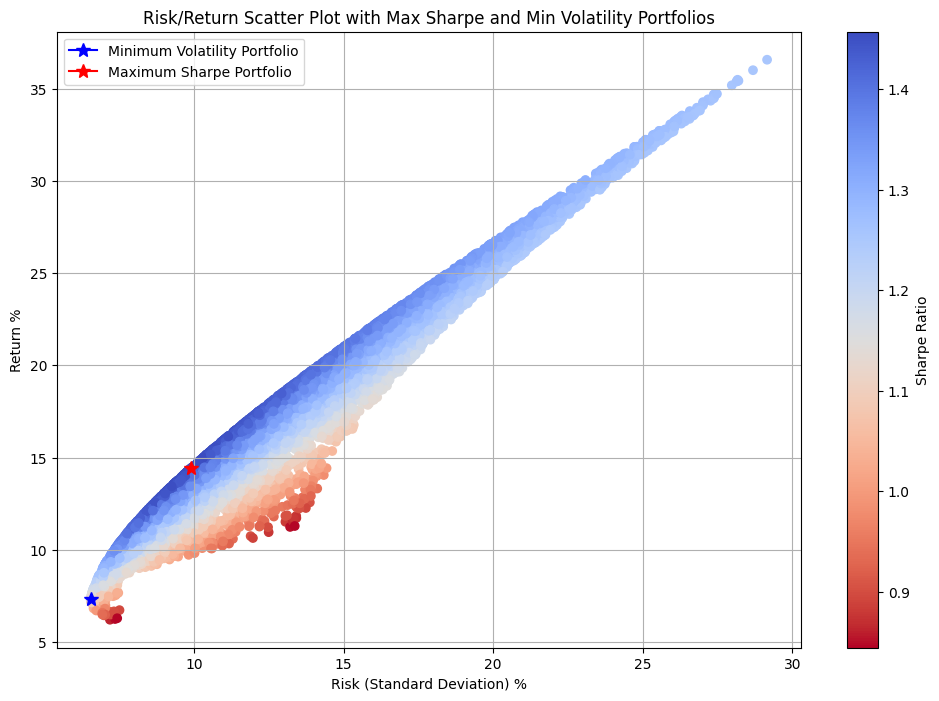

In [132]:
# Find index of the minimum volatility and maximum Sharpe ratio portfolios
min_vol_index = np.argmin(risk_arr)
max_sharpe_index = np.argmax(sharpe_arr)

plt.figure(figsize=(12, 8))

# Plot all portfolios with scatter
plt.scatter(risk_arr * 100, ret_arr * 100, c=sharpe_arr, cmap='coolwarm_r', marker='o')

# Highlight the minimum volatility portfolio with blue star, using plt.plot() for markersize
plt.plot(risk_arr[min_vol_index] * 100, ret_arr[min_vol_index] * 100, color='blue', marker='*', markersize=10, label='Minimum Volatility Portfolio')

# Highlight the maximum Sharpe ratio portfolio with red star, using plt.plot() for markersize
plt.plot(risk_arr[max_sharpe_index] * 100, ret_arr[max_sharpe_index] * 100, color='red', marker='*', markersize=10, label='Maximum Sharpe Portfolio')

# Formatting the axes
plt.title('Risk/Return Scatter Plot with Max Sharpe and Min Volatility Portfolios')
plt.xlabel('Risk (Standard Deviation) %')
plt.ylabel('Return %')
plt.grid(True)

# Add a color bar for Sharpe ratio
plt.colorbar(label='Sharpe Ratio')

# Add the legend
plt.legend()
plt.show()


# Q11: Construct a legend for these two stars, and include in the legend text the x-value (risk), y-value (return) and the Sharpe ratio

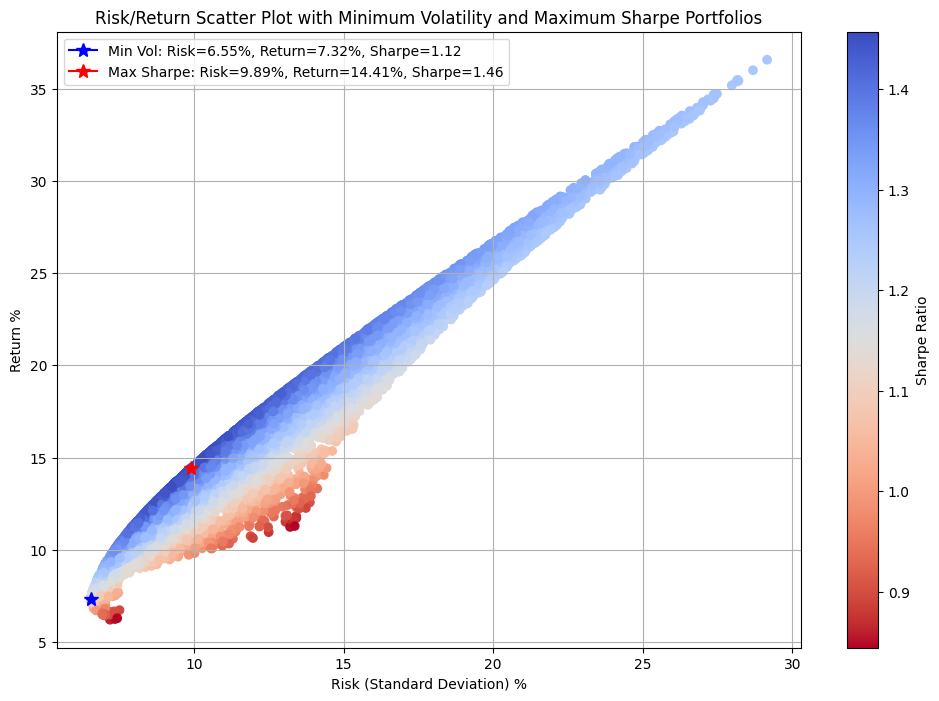

In [133]:
# Find the indices of the minimum volatility and maximum Sharpe ratio portfolios
min_vol_index = np.argmin(risk_arr)
max_sharpe_index = np.argmax(sharpe_arr)

plt.figure(figsize=(12, 8))

# Scatter plot for all portfolios using plt.scatter
plt.scatter(risk_arr * 100, ret_arr * 100, c=sharpe_arr, cmap='coolwarm_r', marker='o')

# Highlight the minimum volatility portfolio using plt.plot() for markersize
plt.plot(risk_arr[min_vol_index] * 100, ret_arr[min_vol_index] * 100, color='blue', marker='*', markersize=10, label=f"Min Vol: Risk={risk_arr[min_vol_index]*100:.2f}%, Return={ret_arr[min_vol_index]*100:.2f}%, Sharpe={sharpe_arr[min_vol_index]:.2f}")

# Highlight the maximum Sharpe ratio portfolio using plt.plot() for markersize
plt.plot(risk_arr[max_sharpe_index] * 100, ret_arr[max_sharpe_index] * 100, color='red', marker='*', markersize=10, label=f"Max Sharpe: Risk={risk_arr[max_sharpe_index]*100:.2f}%, Return={ret_arr[max_sharpe_index]*100:.2f}%, Sharpe={sharpe_arr[max_sharpe_index]:.2f}")

# Add title and labels
plt.title('Risk/Return Scatter Plot with Minimum Volatility and Maximum Sharpe Portfolios')
plt.xlabel('Risk (Standard Deviation) %')
plt.ylabel('Return %')
plt.grid(True)

# Add a color bar for the Sharpe ratio
plt.colorbar(label='Sharpe Ratio')

# Add the legend with both the minimum volatility and maximum Sharpe ratio portfolios
plt.legend()
plt.show()


# Q12: Identify the weight vectors associated with \#9 and \#10

In [134]:
# Extract the weight vectors for the minimum volatility and maximum Sharpe ratio portfolios
min_vol_weights = all_weights[min_vol_index]
max_sharpe_weights = all_weights[max_sharpe_index]

# Create a DataFrame to pretty-print the weights side-by-side
weight_df = pd.DataFrame({
    'Min Vol': min_vol_weights,
    'Max Sharpe': max_sharpe_weights
}, index=merged_data.columns)

# Use the existing print_pct_data function to format the DataFrame
formatted_weights = print_pct_data(weight_df, fmt_spec=".2f")

# Pretty-print the formatted weights DataFrame
formatted_weights

,Min Vol,Max Sharpe
AMZN,0.44%,26.10%
IGLB,74.85%,65.22%
SPY,24.71%,8.68%


**Which Security Dominates the Min-Vol Portfolio?**

IGLB dominates the Min-Vol portfolio with a weight of 74.85%. This is because it has lower volatility and weak correlations with AMZN and SPY, making it the best candidate for reducing overall portfolio risk.

**Is This Consistent with Your Guess in #5?**

Yes and no: IGLB was expected to dominate due to its low risk and weak correlations with the other assets. IGLB's low volatility makes it ideal for minimizing portfolio risk, which is consistent with our guess in Q5.
However, the speculation of AMZN dominating due to its larger Sharpe Ratio was incorrect as IGLB now dominates instead.


**How and Why Do the Weights Change When Going from Min-Vol to Max-Sharpe?**

AMZN's weight increases from 0.44% to 26.1% in the Max-Sharpe portfolio because it offers the highest expected return, despite its higher volatility. This is typical in Sharpe ratio maximization, where higher-return assets are favored.

IGLB's weight decreases from 74.85% to 65.22% in the Max-Sharpe portfolio. Although IGLB is less volatile, its lower returns make it less attractive in a portfolio that seeks to maximize returns relative to risk.

SPY's weight drops from 24.71% to 8.68% because the optimizer shifts more weight toward AMZN, which has a higher Sharpe ratio, reducing SPY's allocation in favor of higher-return assets.


**Summary:**
1. In the Min-Vol portfolio, IGLB dominates due to its low volatility and diversification benefits.
2. In the Max-Sharpe portfolio, the optimizer increases AMZN’s weight for its higher return, while reducing SPY’s and slightly reducing IGLB’s weights to achieve the best risk-adjusted return.

-----
## Honor Pledge
"We pledge on our honor that we have not given nor received any unauthorized assistance on this
assignment to/from other groups. ***Nor have we received any assistance from prior year students.***"
- Pranav Karmarkar, Mohit Jain, Divisha Gupta, Puneetha B.